# Airbnb

Exploratory Data Analysis and Predictive Modeling

- Siddharth Suresh | ss3zg@virginia.edu

In [1]:
# import required libraries and set display options

# to hide warnings
import warnings
warnings.simplefilter('ignore')

# for dataframes and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for progress bar
from tqdm import tqdm

# for getting location details using lat/long
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# for modeling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MedianError
from sklearn.metrics import mean_squared_log_error as MSLE
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from eli5.sklearn import PermutationImportance
import xgboost as xgb
import statsmodels.api as sm
from rfpimp import *

# display all columns
pd.set_option('display.max_columns', None)

In [2]:
listings = pd.read_csv("listings.csv", low_memory=False)

In [3]:
print("Number of columns: " + str(listings.shape[1]))
print("Number of rows: " + str(listings.shape[0]))

Number of columns: 106
Number of rows: 20677


The dataframe has a total of 106 features and 20677 observations.

At first, the aim is to understand the different features and explore each of them.

## Data Clean up

In [4]:
# summarizing the features, unique values in each feature and the null values in each feature

summary_dict = {"Feature": list(listings.columns), "Unique items": list(listings.nunique()), "Null values": list(listings.isna().sum())}
summary_df = pd.DataFrame(summary_dict)
summary_df['% null'] = summary_df["Null values"]/len(listings)*100
summary_df

,Feature,Unique items,Null values,% null
0,id,20677,0,0.000000
1,listing_url,20677,0,0.000000
2,scrape_id,1,0,0.000000
3,last_scraped,3,0,0.000000
4,name,20167,35,0.169270
...,...,...,...,...
101,calculated_host_listings_count,28,0,0.000000
102,calculated_host_listings_count_entire_homes,27,0,0.000000
103,calculated_host_listings_count_private_rooms,14,0,0.000000
104,calculated_host_listings_count_shared_rooms,5,0,0.000000


In [5]:
# Examining the features to segregate them into different groups
display(summary_df[:20])
display(summary_df[20:40])
display(summary_df[40:60])
display(summary_df[60:80])
display(summary_df[80:100])
display(summary_df[100:])

,Feature,Unique items,Null values,% null
0,id,20677,0,0.000000
1,listing_url,20677,0,0.000000
2,scrape_id,1,0,0.000000
3,last_scraped,3,0,0.000000
4,name,20167,35,0.169270
5,summary,19472,629,3.042027
6,space,14843,5422,26.222373
7,description,20172,219,1.059148
8,experiences_offered,1,0,0.000000
9,neighborhood_overview,12780,6584,31.842143


,Feature,Unique items,Null values,% null
20,host_url,17744,0,0.000000
21,host_name,6083,12,0.058035
22,host_since,3046,12,0.058035
23,host_location,581,49,0.236978
24,host_about,9693,8600,41.592107
25,host_response_time,4,8541,41.306766
26,host_response_rate,63,8541,41.306766
27,host_acceptance_rate,0,20677,100.000000
28,host_is_superhost,2,12,0.058035
29,host_thumbnail_url,17718,12,0.058035


,Feature,Unique items,Null values,% null
40,neighbourhood_group_cleansed,0,20677,100.000000
41,city,34,4,0.019345
42,state,52,219,1.059148
43,zipcode,7207,886,4.284954
44,market,4,40,0.193452
45,smart_location,35,0,0.000000
46,country_code,1,0,0.000000
47,country,1,0,0.000000
48,latitude,6189,0,0.000000
49,longitude,10075,0,0.000000


,Feature,Unique items,Null values,% null
60,price,462,0,0.000000
61,weekly_price,333,18086,87.469169
62,monthly_price,296,19269,93.190502
63,security_deposit,152,6202,29.994680
64,cleaning_fee,111,3721,17.995841
65,guests_included,14,0,0.000000
66,extra_people,106,0,0.000000
67,minimum_nights,60,0,0.000000
68,maximum_nights,140,0,0.000000
69,minimum_minimum_nights,59,0,0.000000


,Feature,Unique items,Null values,% null
80,availability_365,366,0,0.000000
81,calendar_last_scraped,3,0,0.000000
82,number_of_reviews,393,0,0.000000
83,number_of_reviews_ltm,127,0,0.000000
84,first_review,2276,2593,12.540504
85,last_review,1396,2593,12.540504
86,review_scores_rating,46,2816,13.618997
87,review_scores_accuracy,8,2827,13.672196
88,review_scores_cleanliness,9,2825,13.662524
89,review_scores_checkin,8,2837,13.720559


,Feature,Unique items,Null values,% null
100,require_guest_phone_verification,2,0,0.000000
101,calculated_host_listings_count,28,0,0.000000
102,calculated_host_listings_count_entire_homes,27,0,0.000000
103,calculated_host_listings_count_private_rooms,14,0,0.000000
104,calculated_host_listings_count_shared_rooms,5,0,0.000000
105,reviews_per_month,743,2593,12.540504


In [6]:
# segregation of features to keep track of the type of feature it is

# features identified that can be removed from the data either due to large % of null values or due to no real value being provided
features_to_be_removed = ['scrape_id', 'last_scraped', 'experiences_offered', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate',
                          'neighbourhood_group_cleansed', 'square_feet', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                          'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'requires_license', 'license', 'jurisdiction_names',
                          'is_business_travel_ready']

# a set of features that mainly contain text describing the observations
descriptive_features = ['id', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules',
                        'picture_url', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'smart_location', 'country_code', 'country', 'is_location_exact',
                        'amenities', 'weekly_price', 'monthly_price', 'security_deposit', 'calendar_updated', 'calendar_last_scraped', 'first_review',
                        'last_review']

# set of features that seem to be important with a preliminary overview
important_features = ['city', 'state', 'zipcode', 'market', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
                      'beds', 'bed_type', 'price', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'has_availability',
                      'availability_30', 'availability_60', 'availability_90', 'availability_365', 'instant_bookable', 'cancellation_policy', 
                      'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                      'calculated_host_listings_count_shared_rooms']

# features exclusively related to the reviews of each of the listings
review_features = ['number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                   'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

# features detailing information about the host
host_descriptions = ['host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate',
                     'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
                     'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'require_guest_profile_picture',
                     'require_guest_phone_verification']

In [7]:
# removing the features not required for analysis

listings_cleaned_columns = listings.drop(columns = features_to_be_removed)
print("Number of columns: " + str(listings_cleaned_columns.shape[1]))

Number of columns: 87


In [8]:
# features to be converted to datetime format
dt_feat = ['host_since', 'first_review', 'last_review', 'calendar_last_scraped']

# changing to datetime format
listings_cleaned_columns.loc[~listings_cleaned_columns[dt_feat[0]].isna(), dt_feat[0]] = pd.to_datetime(listings_cleaned_columns\
                                                                                                      .loc[~listings_cleaned_columns[dt_feat[0]].isna(),
                                                                                                           dt_feat[0]], format = "%Y-%m-%d")
listings_cleaned_columns.loc[~listings_cleaned_columns[dt_feat[1]].isna(), dt_feat[1]] = pd.to_datetime(listings_cleaned_columns\
                                                                                                      .loc[~listings_cleaned_columns[dt_feat[1]].isna(),
                                                                                                           dt_feat[1]], format = "%Y-%m-%d")
listings_cleaned_columns.loc[~listings_cleaned_columns[dt_feat[2]].isna(), dt_feat[2]] = pd.to_datetime(listings_cleaned_columns\
                                                                                                      .loc[~listings_cleaned_columns[dt_feat[2]].isna(),
                                                                                                           dt_feat[2]], format = "%Y-%m-%d")
listings_cleaned_columns.loc[~listings_cleaned_columns[dt_feat[3]].isna(), dt_feat[3]] = pd.to_datetime(listings_cleaned_columns\
                                                                                                      .loc[~listings_cleaned_columns[dt_feat[3]].isna(),
                                                                                                       dt_feat[3]], format = "%Y-%m-%d")
# displaying the %Y-%m-%d format for each of the columns
for feat in dt_feat:
    listings_cleaned_columns[feat] = pd.to_datetime(listings_cleaned_columns[feat])

Now that the features have been sorted into groups, the next step is to clean up the NaN values in the data

### Host information and listing related missing values

There are 12 observations without any host information, since I'd like to include features such as host_since, host_response_rate, host_is_superhost etc. in the models, I will go ahead and drop these rows. This is also justified by the fact that these 12 observations make up 0.06% of the rows in the dataset, so the information loss isn't significant.

Similarly for missing values in bedrooms, bathrooms etc. the rows which have missing values are quite few which can be removed.

In [9]:
# Removing the rows with NaN values in the host related features
listings_cleaned_columns = listings_cleaned_columns.dropna(subset = ['host_is_superhost']).reset_index(drop=True)
listings_cleaned_columns.shape

(20665, 87)

In [10]:
listings_cleaned_columns = listings_cleaned_columns.dropna(subset = ['bedrooms']).reset_index(drop=True)
listings_cleaned_columns.shape

(20657, 87)

In [11]:
listings_cleaned_columns = listings_cleaned_columns.dropna(subset = ['beds']).reset_index(drop=True)
listings_cleaned_columns.shape

(20650, 87)

In [12]:
listings_cleaned_columns = listings_cleaned_columns.dropna(subset = ['bathrooms']).reset_index(drop=True)
listings_cleaned_columns.shape

(20644, 87)

In [13]:
listings_cleaned_columns = listings_cleaned_columns.dropna(subset = ['cancellation_policy']).reset_index(drop=True)
listings_cleaned_columns.shape

(20643, 87)

### Location related missing values

There are observations without the city (4), neighborhood (831), state (219) and zipcode(886) in the dataset. Each of these could be identified using the given latitude and longitudes. Hence, the missing values for these shall be imputed.

In [14]:
# function to find each of the missing variables (takes 4 values: city, neighbourhood, state and zipcode)
def find_missing_locations(row, variable):

    geolocator = Nominatim(user_agent="Random") # Random name for user_agent
    location = geolocator.reverse("{}, {}".format(row.latitude, row.longitude))
    
    # checks for nomenclature
    if variable == 'neighbourhood':
        variable_final = 'residential'
    elif variable == 'zipcode':
        variable_final = 'postcode'
    else:
        variable_final = variable
    
    # checks for the right key in the returned dictionary for 'neighbourhood'
    if variable_final == 'residential':
        if 'residential' in location.raw['address'].keys():
            return location.raw['address'][variable_final]
    
        else:
            return location.raw['address']['suburb']
    # checks for the right key in the returned dictionary for 'zipcode'
    elif variable_final == 'postcode':
        if 'postcode' in location.raw['address'].keys():
            return location.raw['address'][variable_final]
        else:
            return None
    else:
        return location.raw['address'][variable_final]

    

# function to return the dataframe with imputed values
def impute_location_data(df, list_of_variables):
    
    tqdm.pandas() # for progress_bar
    
    # loops through each variable and imputes the values
    for variable in list_of_variables:
        df_lat_long = df.loc[df[variable].isna(), ['latitude', 'longitude']]
        df.loc[df[variable].isna(), variable] = list(df_lat_long.progress_apply(RateLimiter(find_missing_locations, min_delay_seconds=0.1),
                                                                                axis=1, args=[variable]))
    
    return df

In [15]:
%%time
listings_cleaning1 = impute_location_data(listings_cleaned_columns, ['city', 'neighbourhood', 'state', 'zipcode'])

 17%|█▋        | 138/829 [01:08<05:49,  1.98it/s]RateLimiter caught an error, retrying (0/2 tries). Called with (*(latitude     52.32329
longitude     4.96681
Name: 4969, dtype: float64, 'neighbourhood'), **{}).
Traceback (most recent call last):
  File "/Users/siddharthsuresh/opt/anaconda3/lib/python3.7/urllib/request.py", line 1319, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/Users/siddharthsuresh/opt/anaconda3/lib/python3.7/http/client.py", line 1252, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Users/siddharthsuresh/opt/anaconda3/lib/python3.7/http/client.py", line 1298, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Users/siddharthsuresh/opt/anaconda3/lib/python3.7/http/client.py", line 1247, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Users/siddharthsuresh/opt/anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output

CPU times: user 33.1 s, sys: 2.37 s, total: 35.5 s
Wall time: 17min 9s


### Inconsistency in data types

Columns related to prices are strings, which need to be converted to floats. Furthermore, the NaN values for each of these features can be replaced with a zero. This is done for keeping consistency and zero in this case could represent no charge/price/fee for that observation.

Note: Filling NaN values with 0 for these columns also made sense since there weren't any zero values in the data for such rows

In [16]:
listings_cleaning2 = listings_cleaning1.copy()

# features to be converted to float
price_features = ['price', 'cleaning_fee', 'weekly_price', 'monthly_price', 'security_deposit', 'extra_people']

for feature in price_features:
    listings_cleaning2[feature] = listings_cleaning1[feature].str.replace('$','').str.replace(",", "").astype(float)
    listings_cleaning2[feature] = listings_cleaning2[feature].fillna(0) # fill NaN values with zero for consistency 

In [17]:
# drop row where price was zero
listings_cleaning2 = listings_cleaning2.drop([12528]).reset_index(drop=True)

In [18]:
listings_cleaning2.loc[:,price_features].isna().any()

price               False
cleaning_fee        False
weekly_price        False
monthly_price       False
security_deposit    False
extra_people        False
dtype: bool

### Reviews related missing values

Certain review related features have missing values that could be filled up with zeros. Since, about 10% of the rows do not have any first_review and last_review columns which further affect the reviews_per_month column, either such rows could be filled up with zeros or it could be filled up using a central measure (mean or median).

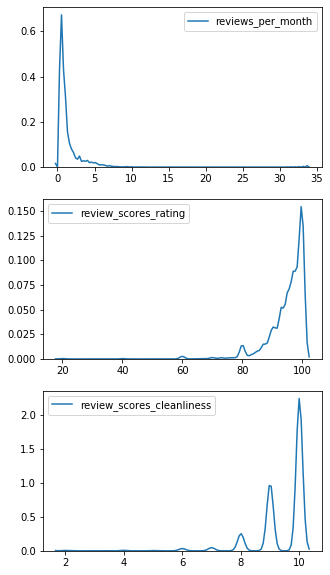

In [19]:
fig, ax = plt.subplots(3, figsize=(5,10))

sns.kdeplot(listings_cleaning2['reviews_per_month'], ax = ax[0])
sns.kdeplot(listings_cleaning2['review_scores_rating'], ax = ax[1])
sns.kdeplot(listings_cleaning2['review_scores_cleanliness'], ax = ax[2])

plt.show()

Due to the skew in the distribution, I will go ahead and impute the values using the median.

In [20]:
listings_cleaning3 = listings_cleaning2.copy()
# features to be imputed
review_features_missing = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin',
                           'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
# instantiating the imputer with strategy = 'median'
imp = SimpleImputer(missing_values=np.nan, strategy='median')

# updating the dataframe with imputed values
listings_cleaning3.loc[:, review_features_missing] = imp.fit_transform(listings_cleaning3[review_features_missing])

In [21]:
listings_cleaning3[review_features_missing].isna().any()

review_scores_rating           False
review_scores_accuracy         False
review_scores_cleanliness      False
review_scores_checkin          False
review_scores_communication    False
review_scores_location         False
review_scores_value            False
reviews_per_month              False
dtype: bool

### Inconsistency in features with Boolean data

Features that contain boolean data needs to be converted into a binary numeric variable for consistency.

In [22]:
airbnb_cleaned = listings_cleaning3.copy()
# boolean features to be cleaned
boolean_features = ['has_availability', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable',
                    'require_guest_profile_picture', 'require_guest_phone_verification']
# mapping from 't' & 'f' to '1' & '0' respectively
boolean_mapping = {'t': 1, 'f': 0}
# create a dictionary for each feature
replacement_dict = {key: boolean_mapping for key in boolean_features}

# replace the boolean features
airbnb_cleaned = airbnb_cleaned.replace(replacement_dict)

In [23]:
airbnb_cleaned.sample(5)

,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
14087,23010059,https://www.airbnb.com/rooms/23010059,Spacious apartment Amsterdam South.,Spacious apartment 70m2. In the best part of A...,NaN,Spacious apartment 70m2. In the best part of A...,NaN,NaN,NaN,NaN,NaN,- Respect for the house and environment.,https://a0.muscache.com/im/pictures/876cbf68-7...,89491992,https://www.airbnb.com/users/show/89491992,Ingrid,2016-08-12,"Amsterdam, North Holland, Netherlands",As a host in my chambre d'hote in Cannes lots...,NaN,NaN,0,https://a0.muscache.com/im/pictures/user/749cc...,https://a0.muscache.com/im/pictures/user/749cc...,Oud-Zuid,1.0,1.0,"['email', 'phone']",1,0,"Amsterdam, Noord-Holland, Netherlands",Oud-Zuid,Zuid,Amsterdam,Noord-Holland,1075 RG,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.35070,4.85929,1,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,Kitchen,Heating,""Smoke detector"",Esse...",100.0,0.0,0.0,0.0,40.0,1,0.0,14,20,5 months ago,1,0,0,0,0,2019-08-08,2,2,2018-08-28,2019-06-24,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,strict_14_with_grace_period,0,0,1,1,0,0,0.17
7143,13136632,https://www.airbnb.com/rooms/13136632,Modern and luxurious apartment in center Amste...,Welcome to our modern and luxurious apartment ...,This apartment has all the luxurious gadgets t...,Welcome to our modern and luxurious apartment ...,Our modern apartment is perfectly situated to ...,NaN,You'll be at Rembrandtsquare and Waterloosquar...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/e5d7cf5f-f...,73191117,https://www.airbnb.com/users/show/73191117,Veronica,2016-05-21,"Amsterdam, North Holland, Netherlands","Mexican married with a Dutch, professional in ...",NaN,NaN,0,https://a0.muscache.com/im/pictures/05058258-3...,https://a0.muscache.com/im/pictures/05058258-3...,Oostelijke Eilanden en Kadijken,1.0,1.0,"['phone', 'reviews', 'jumio']",1,0,"Amsterdam, Noord-Holland, Netherlands",Oostelijke Eilanden en Kadijken,Centrum-Oost,Amsterdam,Noord-Holland,1018 NM,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.37174,4.93012,1,Apartment,Entire home/apt,3,1.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",150.0,0.0,0.0,0.0,35.0,2,15.0,2,1125,33 months ago,1,0,0,0,0,2019-08-08,7,0,2016-06-13,2016-10-09,83.0,8.0,8.0,10.0,9.0,9.0,9.0,0,flexible,0,0,1,1,0,0,0.18
12379,20385230,https://www.airbnb.com/rooms/20385230,Cozy Studio @ Dam Square,Location! Location! Location!,NaN,Location! Location! Location!,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/abe80dc9-a...,16294860,https://www.airbnb.com/users/show/16294860,Gunnar Torfi,2014-06-02,"Setagaya, Tokyo, Japan",NaN,NaN,NaN,0,https://a0.muscache

## Exploratory analysis

The two key features in the dataset are:
- Price
- Availability

There is a need to understand how different features affect each of them. I will be exploring some of the features to better understand their effects on each of the two.

### Location related features

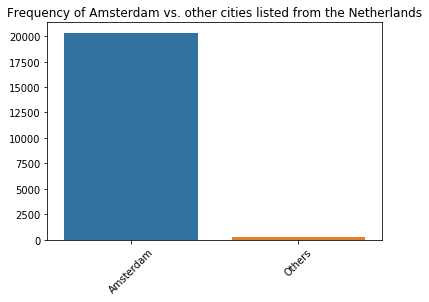

In [24]:
# Cities covered in the dataset
amsterdam = len(airbnb_cleaned[airbnb_cleaned.city == "Amsterdam"])
not_amsterdam = len(airbnb_cleaned[airbnb_cleaned.city != "Amsterdam"])

sns.barplot(['Amsterdam', 'Others'], [amsterdam, not_amsterdam])
plt.xticks(rotation = 45)
plt.title("Frequency of Amsterdam vs. other cities listed from the Netherlands")
plt.show()

Since majority of the listings are from Amsterdam the price and availability shouldn't be affected too much by the city. However, it might be affected by the neighborhood. Let's check that out

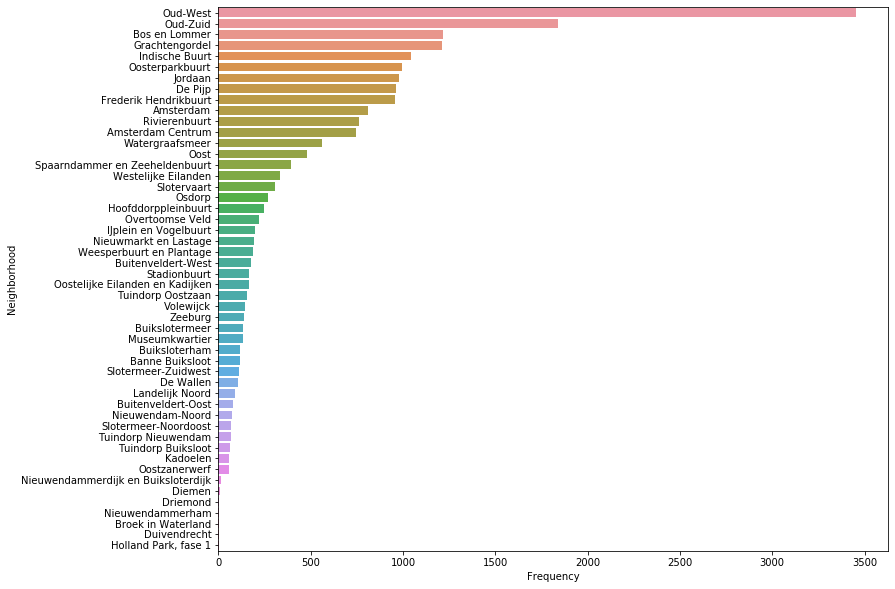

In [25]:
# Neighborhoods covered in the dataset
fig = plt.subplots(figsize=(12,10))
sns.barplot(x = "neighbourhood", y = "index", data = pd.DataFrame(airbnb_cleaned.neighbourhood.value_counts()).reset_index())
plt.xlabel("Frequency")
plt.ylabel("Neighborhood")
plt.show()

The distribution amongst different neighborhoods is quite diverse with majority of the listings in the top 15 neighborhoods (~80%). Hence, it will be interesting to see how price/availability varies according to the neighborhood location

### Host related features

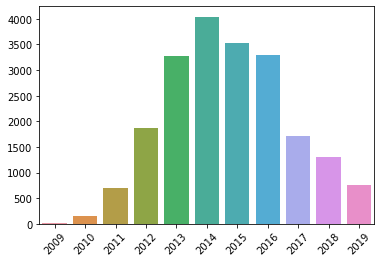

In [26]:
years = list(range(2009, 2020))
host_since_freq = []

for year in years:
    host_since_freq.append(len(airbnb_cleaned[airbnb_cleaned['host_since'].dt.year == year]))

sns.barplot(years, host_since_freq)
plt.xticks(rotation=45)
plt.show()

Most hosts have been listing on airbnb since 2014, which means that there are quite a few hosts that have a lot of experience in hosting. This may affect the pricing strategies in some way which could be explored.

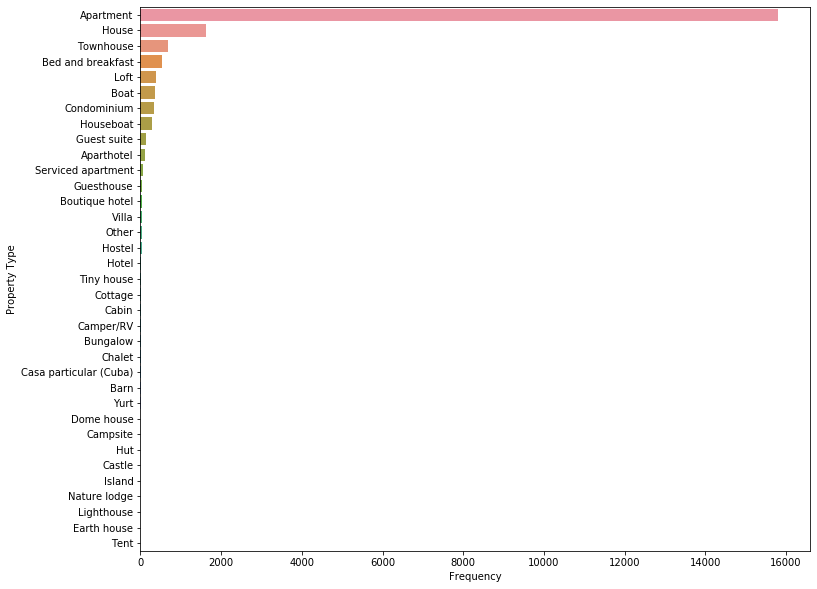

In [27]:
# properties covered in the dataset
fig = plt.subplots(figsize=(12,10))
sns.barplot(x = "property_type", y = "index", data = pd.DataFrame(airbnb_cleaned.property_type.value_counts()).reset_index())
plt.xlabel("Frequency")
plt.ylabel("Property Type")
plt.show()

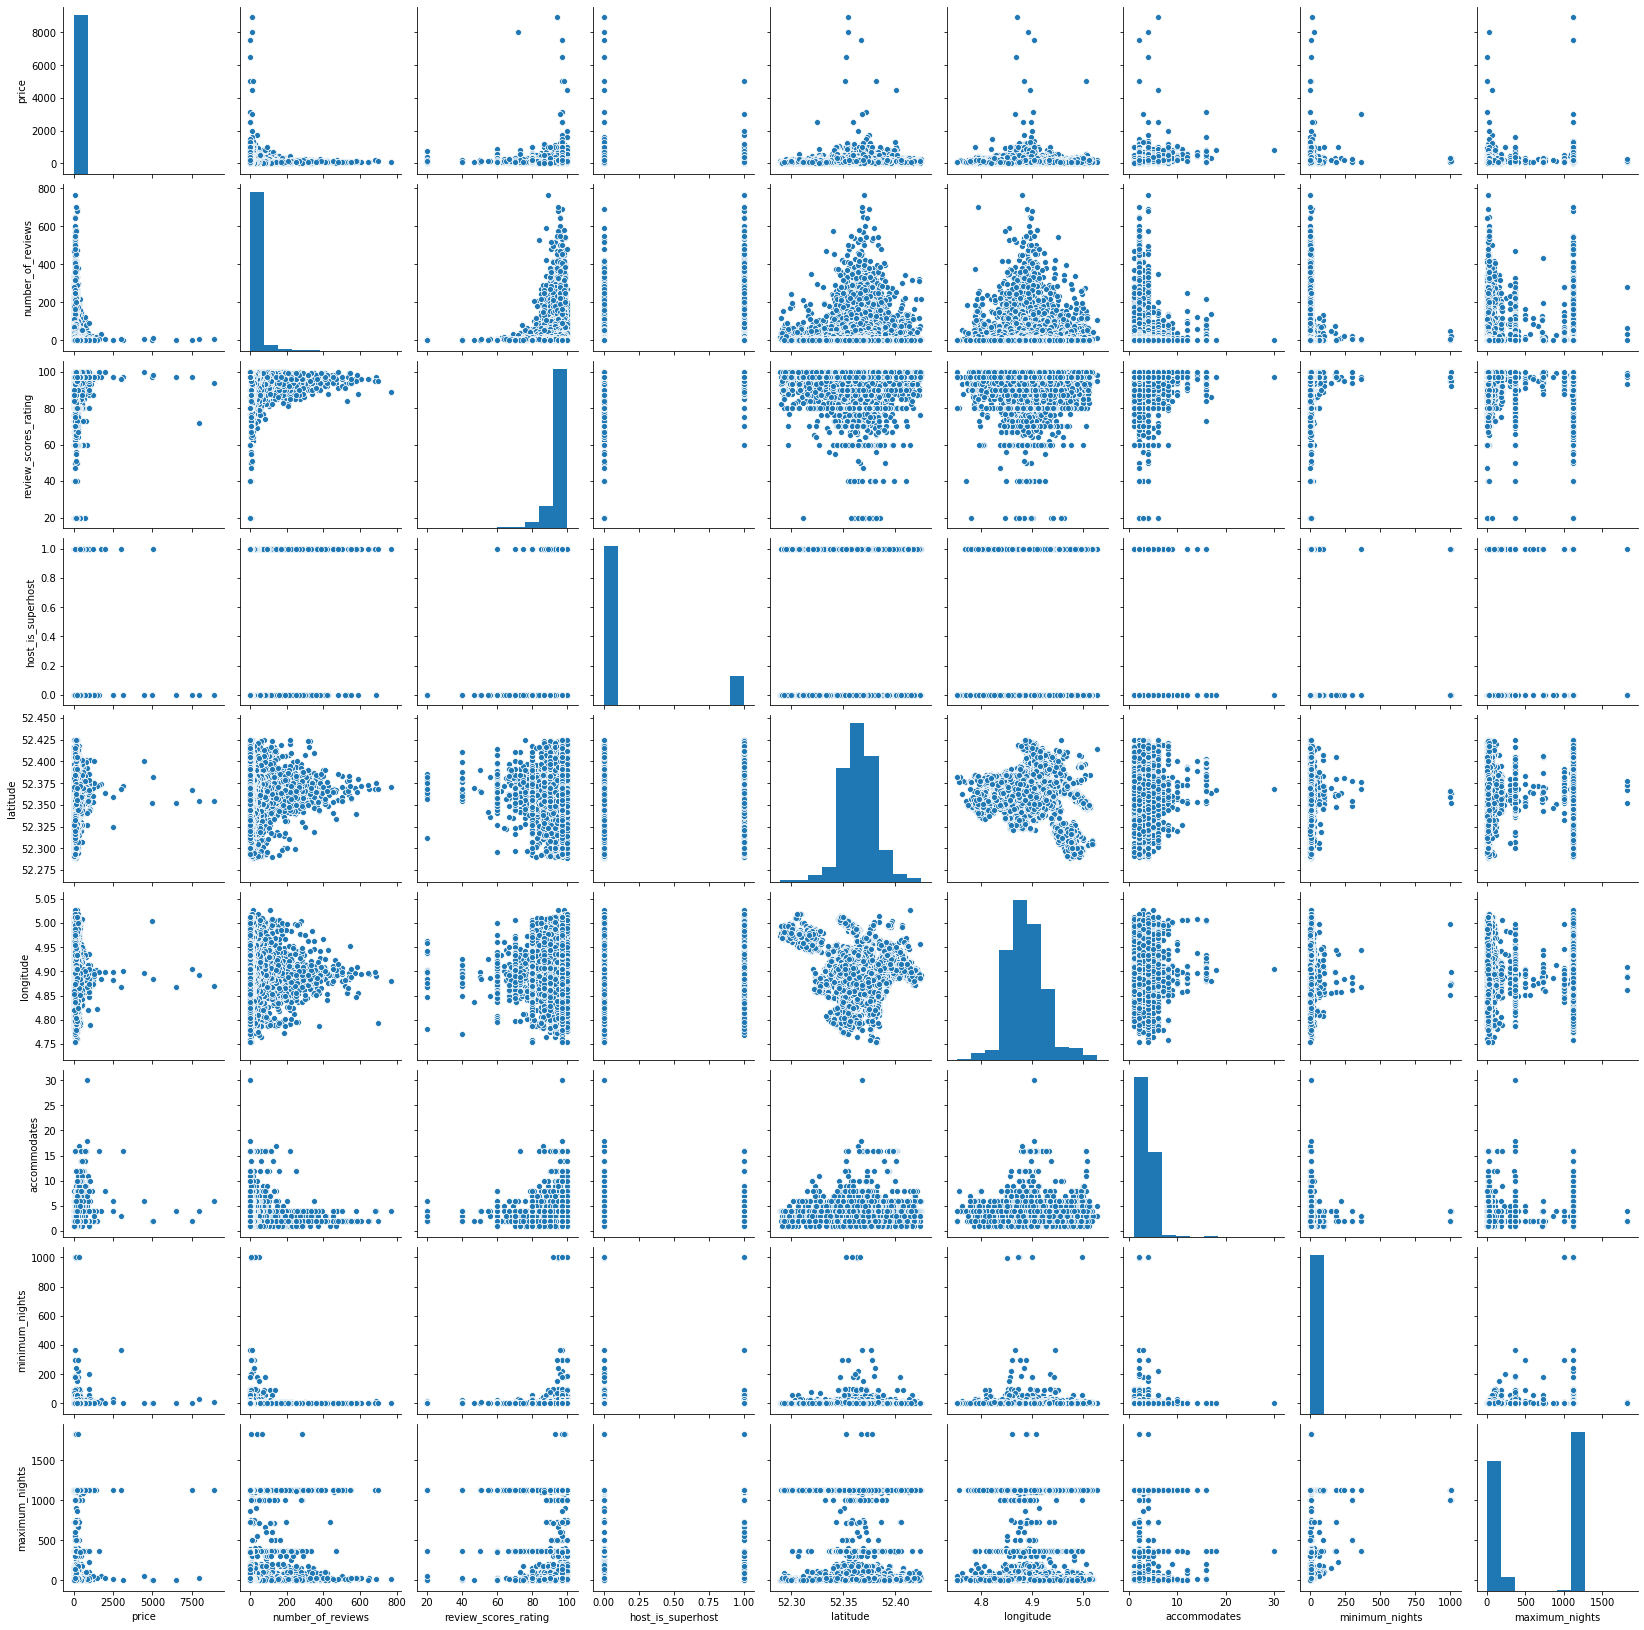

In [28]:
# overview of relationship between different features
g = sns.pairplot(airbnb_cleaned[['price', 'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'latitude', 'longitude', 'accommodates', 'minimum_nights', 'maximum_nights']])

## Feature engineering

In [29]:
# grouping neighbourhoods into 5 bins based on frequency
top2_neighbourhoods = list(airbnb_cleaned.neighbourhood.value_counts().index[:2])
top4_neighbourhoods = list(airbnb_cleaned.neighbourhood.value_counts().index[2:4])
top7_neighbourhoods = list(airbnb_cleaned.neighbourhood.value_counts().index[4:7])
top10_neighbourhoods = list(airbnb_cleaned.neighbourhood.value_counts().index[7:10])
top20_neighbourhoods = list(airbnb_cleaned.neighbourhood.value_counts().index[10:20])
bottom30_neighbourhoods = list(airbnb_cleaned.neighbourhood.value_counts().index[20:50])

airbnb_cleaned['neighbourhood_cat'] = ['top2' if x in top2_neighbourhoods else 'top4' if x in top4_neighbourhoods else 'top7' if x in top7_neighbourhoods else\
                                       'top10' if x in top10_neighbourhoods else 'top20' if x in top20_neighbourhoods else\
                                       'bottom30' for x in airbnb_cleaned.neighbourhood]

In [30]:
# changing room-type into a binary variable that checks whether the listing is entire home or a single room
airbnb_cleaned['entire_home'] = [1 if x == 'Entire home/apt' else 0 for x in airbnb_cleaned.room_type]

In [31]:
# changing host_since into days
airbnb_cleaned['host_days_since'] = (airbnb_cleaned['calendar_last_scraped'] - airbnb_cleaned['host_since']).dt.days

In [32]:
# grouping property type into smaller bins
airbnb_cleaned['property'] = ['Apartment' if x in ['Apartment', 'Condominium', 'Aparthotel', 'Guest suite'] else 'House' if x in ['House', 'Townhouse', 'Guesthouse', 'Villa', 'Bungalow'] else 'Other' for\
                             x in airbnb_cleaned['property_type']]

## Models

### Price prediction: Linear Model

In [33]:
# selected features
features_pricing_model = ['longitude', 'entire_home', 'bathrooms', 'accommodates', 'minimum_nights', 'maximum_nights',
                          'cleaning_fee', 'availability_30', 'availability_90', 'availability_365', 'bedrooms', 'property', 'neighbourhood_cat',
                          'host_listings_count', 'review_scores_location', 'review_scores_value', 'cancellation_policy', 'calculated_host_listings_count_entire_homes',
                          'number_of_reviews', 'review_scores_rating', 'host_is_superhost', 'host_identity_verified',
                          'review_scores_accuracy', 'number_of_reviews_ltm', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication']
features_pricing_model.sort()


data = airbnb_cleaned[features_pricing_model + ['price']]
data = pd.get_dummies(data, drop_first=True) # dummy variables

column_sequence = list(data.columns)
column_sequence.remove("price")
column_sequence += ["price"]

data = data[column_sequence]

# standardize the data
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

X = scaled_data.drop(columns = ['price'])
y = scaled_data[['price']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

In [34]:
# OLS estimation of coefficients
lm = sm.OLS(y_train, X_train)
result = lm.fit_regularized(L1_wt = 0.5, alpha = 0.01, refit = True)
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.203
Model:                            OLS   Adj. R-squared (uncentered):              0.202
Method:                 Least Squares   F-statistic:                              168.2
Date:                Wed, 20 May 2020   Prob (F-statistic):                        0.00
Time:                        19:27:30   Log-Likelihood:                         -20991.
No. Observations:               16513   AIC:                                  4.203e+04
Df Residuals:                   16488   BIC:                                  4.223e+04
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----

In [35]:
# predictions on test set
y_preds_lm = result.predict(X_test)

# transform back to non-standardized values
train_unscaled = pd.DataFrame(scaler.inverse_transform(pd.concat([X_train, y_train], axis = 1)), columns = data.columns)
test_unscaled = pd.DataFrame(scaler.inverse_transform(pd.concat([X_test, y_test], axis = 1)), columns = data.columns)
preds_unscaled = pd.DataFrame(scaler.inverse_transform(pd.concat([X_test, y_preds_lm], axis = 1)), columns = data.columns)

# print metrics
print("RMSE: " + str(MSE(test_unscaled['price'], preds_unscaled['price'])**(1/2)))
print("Median Absolute Error: " + str(MedianError(test_unscaled['price'], preds_unscaled['price'])))

RMSE: 167.47654577428256
Median Absolute Error: 33.07758339001481


For the linear regression model, a combination of different features were put together and scaled using a standard scaler. Each of the combinations were evaluated through the MSE and Median Absolute Error. Furthermore, an elasticnet method was used with L1 weight as 0.5 to have an equal weightage of Ridge and Lasso & a penalty of 0.01. This proved to be helpful as quite a few features' coefficients were set to 0.

Since, this model has a lot of interpretability, we can go through the effects of each feature on price. Some key highlights from the finalized model were:
- has an RMSE of ~167 which is not bad for a model with interpretability
- has a median absolute error of 33, which means based on the median absolute error, there is a difference of $33 between the actual price and the predicted values, which again isn't too bad
- The greater the room for accommodation, the greater the price, which is intuitive as price should be higher for listings that can accommodate more people. This is further elucidated by positive coefficients for bathroom and bedrooms
- The longer the availability, the higher the price. This needs to be understood as it isn't obviously clear in my mind why the price would be higher for houses that aren't getting booked in advance (houses that have higher availability)
- Higher the number of entire homes hosted by the host, lower the price. This makes sense because a host who is hosting multiple airbnbs (entire homes) has multiple revenue streams and thus can be competitive and offer lower rates on his/her listings.
- Neighborhoods that have high density of airbnbs usually have listings with higher prices, which is what is seen in real life. The baseline for this categorical variable is the neighborhood with least density of airbnbs
- Strict cancellation policies usually come with higher prices. The baseline for this categorical variable is a flexible cancellation policy. This means that while moderate cancellation policies usually come with lower prices than that for flexible policies, the super strict policies come with higher prices than flexible policies. This could be explored further to understand why higher prices come with the super strict policies. My hunch is that such cancellation policies are only for airbnbs with high demand, and hence could be prime properties.
- The higher the review rating on 'value', the lower the price, which makes sense since a higher rating for this field means people think it was worth their buck and/or exceeded their expectations
- The airbnbs on the eastern parts of the entire area are more expensive based on the longitude coefficient.
- Other features with +ve coefficients: 'superhost', 'high review scores for location'
- Other features with -ve coefficients: as compared to apartment prices, houses are usually cheaper, while other unique kinds of stays are costlier.

### Price prediction: Random Forest Model

In [36]:
# features selected
features_pricing_model = ['longitude', 'entire_home', 'bathrooms', 'accommodates', 'minimum_nights', 'maximum_nights',
                          'cleaning_fee', 'availability_30', 'availability_90', 'availability_365', 'neighbourhood_cat',
                          'host_listings_count', 'review_scores_location', 'review_scores_value', 'cancellation_policy', 'calculated_host_listings_count_entire_homes',
                          'review_scores_rating', 'host_is_superhost', 'host_identity_verified', 'bedrooms', 'property', 'number_of_reviews',
                          'review_scores_accuracy', 'number_of_reviews_ltm', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication']
features_pricing_model.sort()

X = airbnb_cleaned[features_pricing_model]
X = pd.get_dummies(X) # one-hot encoding
y = airbnb_cleaned['price']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

# Note: For random forest model, standarization isn't necessary

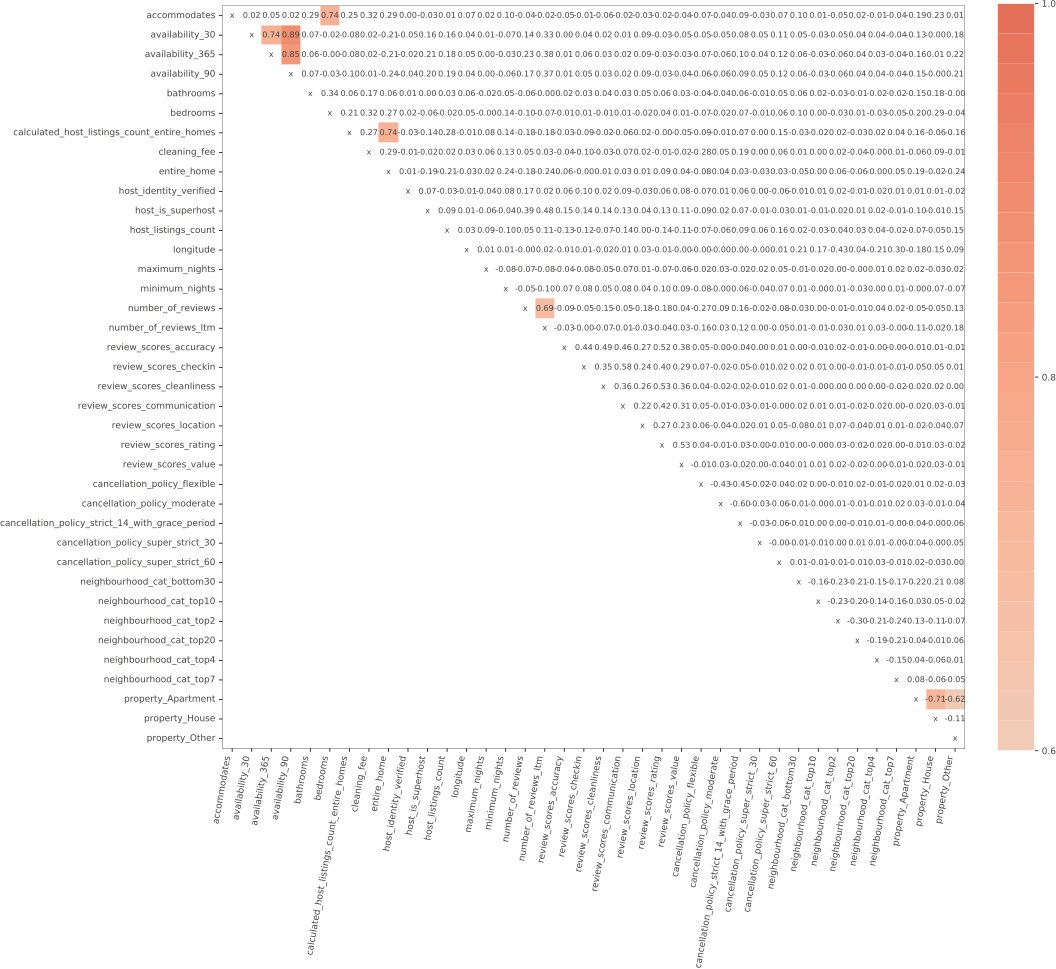

In [37]:
# check correlation between features
plot_corr_heatmap(X, figsize=(15,15))

Scores:
Training score: 0.8733746671171918
Test score: 0.15232009824795212
OOB score: 0.0462178170316645
Results:
RMSE: 168.19851401633133
Median Absolute Error: 28.459999999999994
Feature Importance:


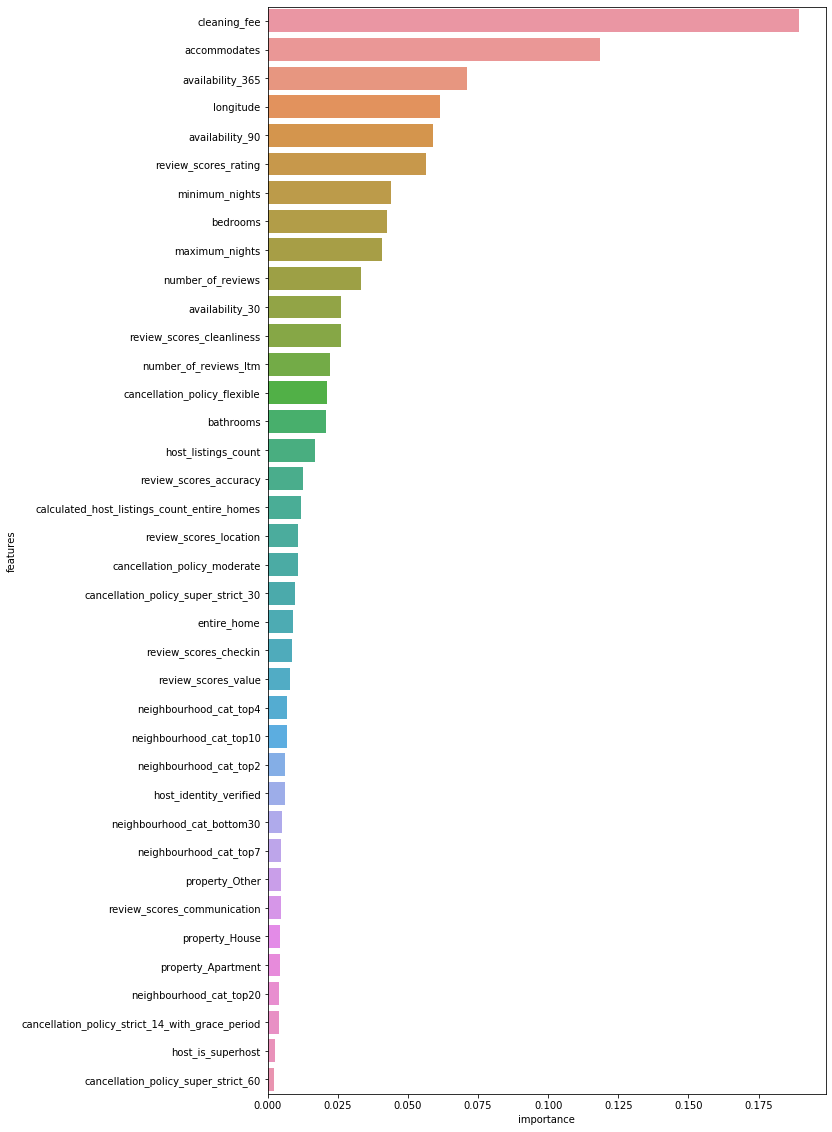

In [38]:
# Random Forest model with 500 trees
rf = RandomForestRegressor(n_estimators = 500, oob_score = True, random_state = 3, n_jobs = -1)
rf.fit(X_train, y_train)

# feature importances
feat_importances = pd.DataFrame({'features': X_train.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending = False)

# results
print("="*20)
print("Scores:")
print("Training score: " + str(rf.score(X_train, y_train)))
print("Test score: " + str(rf.score(X_test, y_test)))
print("OOB score: " + str(rf.oob_score_))

print("="*20)
print("Results:")
y_preds_rf = rf.predict(X_test)
print("RMSE: " + str(MSE(y_test, y_preds_rf)**(1/2)))
print("Median Absolute Error: " + str(MedianError(y_test, y_preds_rf)))

print("="*20)
print("Feature Importance:")
fig = plt.subplots(figsize = (10, 20))
sns.barplot(x = 'importance' , y = 'features', data = feat_importances)
plt.show()

In [39]:
# perm_imp = PermutationImportance(rf, scoring = 'neg_mean_squared_error').fit(X_test, y_test)
# df_perm = pd.DataFrame({'features': X_test.columns, 'importance': perm_imp.feature_importances_}).sort_values('importance', ascending = False)

# fig = plt.subplots(figsize = (10, 20))
# sns.barplot(x = 'importance' , y = 'features', data = df_perm)
# plt.show()

Using the Random Forest Model, the RMSE was 168, slightly higher than the Linear Regression model. However, the median absolute error is lower at $28. This performance isn't too bad either, however given that there is a loss of interpretability, I wouldn't choose this model over the Linear Regression Model .

### Price prediction: XGBoost

In [40]:
# features selected
features_pricing_model = ['longitude', 'entire_home', 'bathrooms', 'accommodates', 'minimum_nights', 'maximum_nights',
                          'cleaning_fee', 'availability_30', 'availability_90', 'availability_365', 'neighbourhood_cat',
                          'host_listings_count', 'review_scores_location', 'review_scores_value', 'cancellation_policy', 'calculated_host_listings_count_entire_homes',
                          'review_scores_rating', 'host_is_superhost', 'host_identity_verified', 'bedrooms', 'property', 'number_of_reviews',
                          'review_scores_accuracy', 'number_of_reviews_ltm', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication']
features_pricing_model.sort()

X = airbnb_cleaned[features_pricing_model]
X = pd.get_dummies(X) # one-hot encoding
y = airbnb_cleaned['price']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

# Note: For XGBoost model, standarization isn't necessary

Scores:
Training score: 0.9181822731012117
Test score: 0.19383855982299458
Results:
MSE: 164.02771017017415
Median Absolute Error: 27.01708984375
Feature Importance for XGBoost:


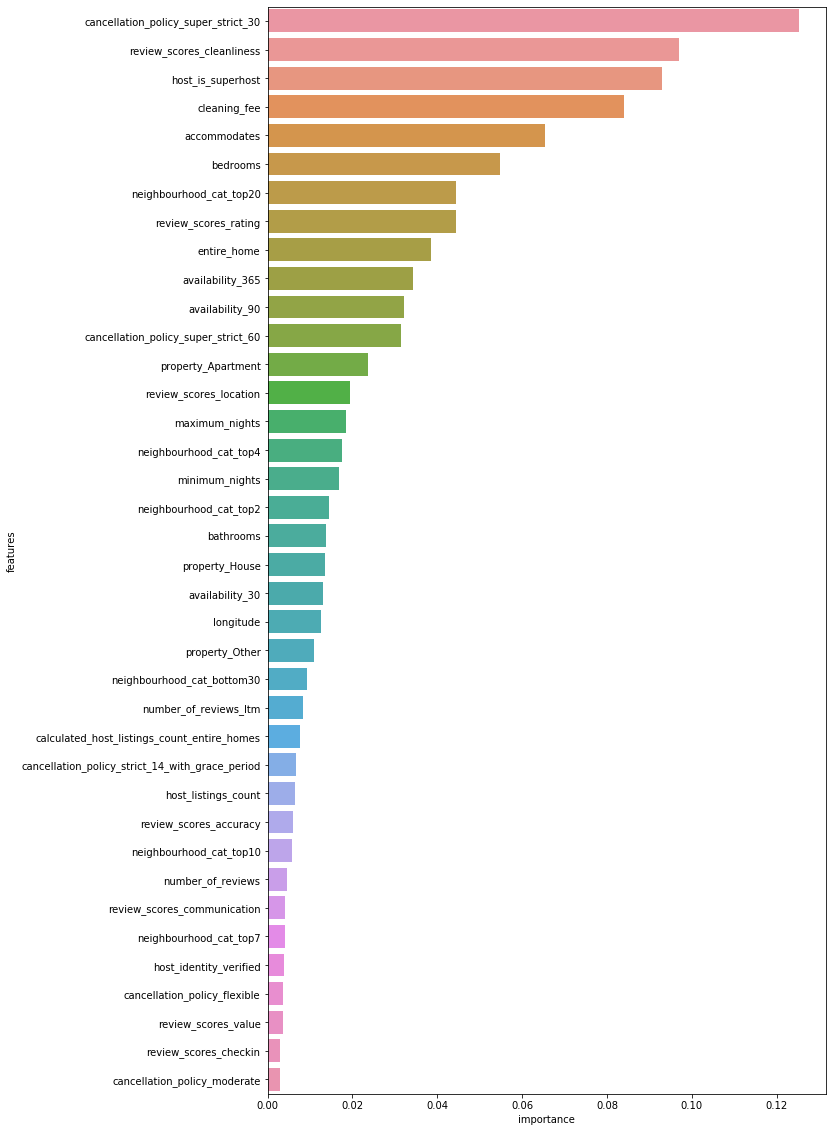

In [41]:
# XGBoost model
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

feat_importances_xgb = pd.DataFrame({'features': X_train.columns, 'importance': xgb_reg.feature_importances_}).sort_values('importance', ascending = False)

print("="*20)
print("Scores:")
print("Training score: " + str(xgb_reg.score(X_train, y_train)))
print("Test score: " + str(xgb_reg.score(X_test, y_test)))

print("="*20)
print("Results:")
y_preds_xgb = xgb_reg.predict(X_test)
print("MSE: " + str(MSE(y_test, y_preds_xgb)**(1/2)))
print("Median Absolute Error: " + str(MedianError(y_test, y_preds_xgb)))

print("="*20)
print("Feature Importance for XGBoost:")
fig = plt.subplots(figsize = (10, 20))
sns.barplot(x = 'importance' , y = 'features', data = feat_importances_xgb)
plt.show()

The XGBoost model definitely fits better than the Random Forest model due to the boosted trees, but it still has an RMSE of 164 and a Median Absolute Error of $27 which is not significantly lower than the Random Forest. Since, this model isn't significantly better than the Linear Regression Model given that there is loss of interpretability, I would go ahead and choose the Linear Model as the final model.